In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from generate_chunks import load_data
from train_models import ModelTrainer
from failure_detection import print_failures, simple_lowpass_filter

model_name = 'TCN'
model = ModelTrainer(f'configs/{model_name}.json').fit()
train_chunks, training_chunk_dates, test_chunks, test_chunk_dates = load_data(version=model.version, scaler=model.scaler)

val_size = int(0.3 * len(train_chunks))
train_errors = model.calc_loss(train_chunks[-val_size:], train_chunks[-val_size:], average=False).mean(axis=(1,2))
test_errors_raw = model.calc_loss(test_chunks, test_chunks, average=False)
test_errors = test_errors_raw.mean(axis=(1,2))

q99 = np.quantile(train_errors, [0.99])
anom = 3*q99

binary_output = (test_errors > anom).astype(np.int8)
output = simple_lowpass_filter(binary_output, 0.15)
np.save('data/pt2_tcn_output.npy', output.squeeze())
failures = (output > 0.5).astype(np.int8)
print_failures(test_chunk_dates, failures)



[2022-06-04 08:43:36.136000, 2022-06-04 17:09:07.703000]
[2022-07-11 08:32:47.460000, 2022-07-14 13:10:01.141000]


[Interval(2022-06-04 08:43:36.136000, 2022-06-04 17:09:07.703000, closed='both'),
 Interval(2022-07-11 08:32:47.460000, 2022-07-14 13:10:01.141000, closed='both')]

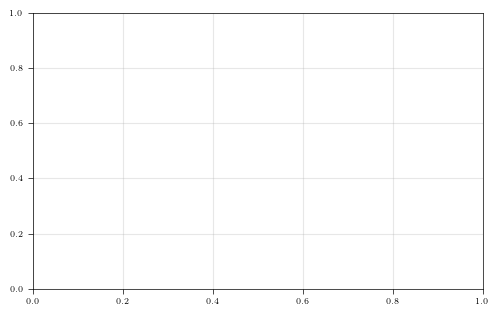

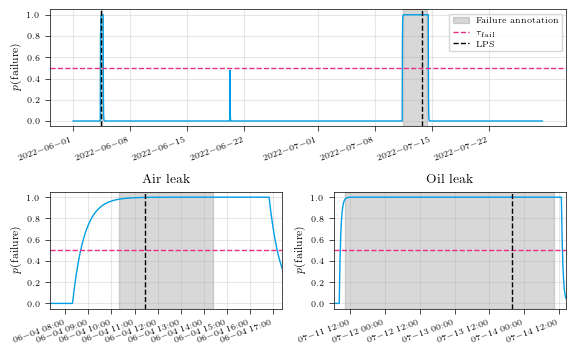

In [ ]:

from plotz import COLORS, default_plot

feature_names = ['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Oil_temperature', 'Flowmeter', 'Motor_current', 'COMP']

actual_failures = [
    (np.datetime64('2022-06-04T10:19:24'), np.datetime64('2022-06-04T14:22:39')),
    (np.datetime64('2022-07-11T10:10:18'), np.datetime64('2022-07-14T10:22:08')),
]

gs = gridspec.GridSpec(2,2)
#fig, axs = default_plot(width_fraction=1, height_fraction=1.25, sharey=True, style='dissertation')
fig, axs = default_plot(width_fraction=1, height_fraction=0.75, sharey=True, style='beamer-lamarr')
#fig, axs = default_plot(width_fraction=1, height_fraction=1, sharey=True, style='ieeeaccess')
fig = plt.figure(figsize=fig.get_size_inches())
plt.rcParams.update({'date.autoformatter.hour': '%m-%d %H:00'})

rot = 20

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

for idx, ax in enumerate([ax1, ax2, ax3]):
    for idx2, (start, end) in enumerate(actual_failures):
        ax.axvspan(start, end, color='grey', alpha=0.3, label='Failure annotation' if idx == 0 and idx2 == 0 else '')

    ax.plot(test_chunk_dates[:, 1], output, color='C1', label='' if idx == 0 else '')
    ax.axhline(y=0.5, color=COLORS.red, linestyle='--', label=r'$\tau_{\textrm{fail}}$' if idx==0 else '')
    ax.set_ylabel(r'$p(\textrm{failure})$')

    ax.axvline(x=np.datetime64('2022-06-04T11:26:01.422000000'), color='black', linestyle='--', label='LPS' if idx == 0 else '')
    ax.axvline(x=np.datetime64('2022-07-13T19:43:52.593000000'), color='black', linestyle='--')

ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=rot, ha='right')

ax2.set_xlim(actual_failures[0][0]-np.timedelta64(3, 'h'), actual_failures[0][1]+np.timedelta64(3, 'h'))
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=rot, ha='right')
ax2.set_title('Air leak')
ax3.set_xlim(actual_failures[1][0]-np.timedelta64(4, 'h'), actual_failures[1][1]+np.timedelta64(4, 'h'))
ax3.set_xticks(ax3.get_xticks(), ax3.get_xticklabels(), rotation=rot, ha='right')
ax3.set_title('Oil leak')

#fig.legend(bbox_to_anchor=(0.98, 0.97))
ax1.legend()
fig.tight_layout()
fig.savefig('plots/figure3.pdf', transparent=True, bbox_inches='tight')
#fig.savefig('plots/prob_results.pdf', transparent=True, bbox_inches='tight')